# Natural Language Processing

Today, we will cover Natural Language Processing in Python, using the nltk and gensim packages.

Friendly Reminders:

* Project Showcase on Thursday, 5/9 (last day of class)

In [1]:
%pylab inline
import requests, re
import pandas as pd
import seaborn as sns
import nltk
pd.set_option('max_columns', 40)
pd.set_option('colwidth', 300)

Populating the interactive namespace from numpy and matplotlib


## NBA Mock Draft Data

Each year, National Basketball Association (NBA) teams participate in an amateur draft, through which they can acquire the rights to sign new players to contracts for the upcoming season(s). Much effort is dedicated to evaluating the potential of the players, including a substantial amount of scouting, either during their play for previous organizations (e.g., National Collegiate Athletics Association, international professional leagues) or at the NBA draft combine where players are given an opportunity to showcase their potential. In addition to their statistical output, there are many characteristics of players that are best captured via scouting reports, which requires manual review or natural language processing to analyze.

In [4]:
# Import mock draft table
path = '/Users/charmain/Desktop/Master Degree/Term 2/Data Processing & Analysis in Python/Data Files/'
df = pd.read_csv(path + 'nba_draft_scouting_reports2018.csv')
df.head(2)

,#,Team,Player,H,W,P,School,C,url,Strengths,Weaknesses
0,1,Phoenix,DeAndre Ayton,7-0,260,C,Arizona,Fr.,http://www.nbadraft.net/players/deandre-ayton,Posesses can't miss talent with the chance to develop into a generational big ... Seven-footer with great coordination and fluidity ... Great size and length with a 7'5.5 wingspan and 9'3 standing reach ... Runs the floor well with great agility ... Good strength level as well as body frame. Ver...,"Ayton didn't make the strides one would hope in his senior year ... He did seem more focused towards the end of the season after losing his #1 player in class status nearly universally, but it appeared he got too comfortable sitting at the top spot for too long ... He rarely played like he had a..."
1,2,Memphis,Marvin Bagley,6-11,235,PF,Duke,Fr.,http://www.nbadraft.net/players/marvin-bagley,"NBA-ready body ... Positional versatility ... Displays unusually smooth and fluid movements for his 6'11"", 234-pound frame ... Elite and agile athlete ... Great lateral quickness ... Exceptional leaper (jumps well off both feet) ...Elevates quickly and really gets off the floor well for his seco...",Lacks the wingspan of other big men in his class ... Has to continue to fill out his frame with upper and lower body strength ... Sometimes gets out-muscled in the paint/post ... Lack of strength keeps him from controlling the paint on defense ... Ball handling is solid but still needs to get be...


## Natural Language Processing

As suggested by the name, the majority of the work in the NLP space involves text processing tasks. We have already developed several categories of techniques that also contribute to NLP:

* Scalar string methods (e.g., .split, .lower)
* Regular expressions (e.g., .search, .match, .sub, .split)
* Vectorized string methods in pandas (.str)

These methods form the foundation for NLP, but the nltk (Natural Language Toolkit) and gensim packages offer substantially more functionality. There is also some functionality in scikit-learn, you can explore these features at: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction.

Let's begin by importing a few objects from the nltk and gensim packages and re-loading the NBA draft prospects data.

In [5]:
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans

/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


Let's select the scouting report (i.e., strengths or weaknesses) for a specific player:

In [6]:
# Select scouting report for review
pid = 1
report = 'Strengths'
print(df[['Player','H','W','P','School','C']].loc[pid])
s = df.at[pid, report]
s

Player    Marvin Bagley
H                  6-11
W                   235
P                    PF
School             Duke
C                   Fr.
Name: 1, dtype: object


'NBA-ready body ... Positional versatility ... Displays unusually smooth and fluid movements for his 6\'11", 234-pound frame ... Elite and agile athlete ... Great lateral quickness ... Exceptional leaper (jumps well off both feet) ...Elevates quickly and really gets off the floor well for his second and third jumps ... Plays effortlessly above the rim ... Possesses great hands and quick feet... Catches everything that comes his way ... Very coordinated in his movements ... Has good body control ... Good overall ball-handler for a big man ... Multifaceted offensive skillset ... Versatile/natural scorer ... Polished footwork in the post ... Can shoulder his team\'s offensive load ... Gets to the rim easily ... Strong finisher around the basket with a soft touch ... Can score around the rim with either hand ... Solid low post scorer ... Possesses a bevy of floaters, runners, and hook shots ... Gets his defenders off balance with an array of ball fakes ... Does a good job of working around

The first set of NLP steps to consider involve standardizing the text:

* Converting to lower case
* Removing punctuation
* Tokenization
* Removing stop words
* Stemming/Lemmatization

In [7]:
# Convert text to lower case
s = s.lower()

In [8]:
# Remove unnecessary punctuation
s = re.sub('[,()]', '', s)

Tokenization is the process of converting a body of text (string) into a list of singular elements (tokens). The nltk package offers several methods for tokenization, the most commonly used are:

* Word tokenization (**word_tokenize**)
* Sentence tokenization (**sent_tokenize**)
* Regex tokenization (**regex_tokenize**)

The type of tokenization that you use depends on the granularity required for your analysis.

In [9]:
# Word tokenization
print(word_tokenize(s))

['nba-ready', 'body', '...', 'positional', 'versatility', '...', 'displays', 'unusually', 'smooth', 'and', 'fluid', 'movements', 'for', 'his', "6'11", "''", '234-pound', 'frame', '...', 'elite', 'and', 'agile', 'athlete', '...', 'great', 'lateral', 'quickness', '...', 'exceptional', 'leaper', 'jumps', 'well', 'off', 'both', 'feet', '...', 'elevates', 'quickly', 'and', 'really', 'gets', 'off', 'the', 'floor', 'well', 'for', 'his', 'second', 'and', 'third', 'jumps', '...', 'plays', 'effortlessly', 'above', 'the', 'rim', '...', 'possesses', 'great', 'hands', 'and', 'quick', 'feet', '...', 'catches', 'everything', 'that', 'comes', 'his', 'way', '...', 'very', 'coordinated', 'in', 'his', 'movements', '...', 'has', 'good', 'body', 'control', '...', 'good', 'overall', 'ball-handler', 'for', 'a', 'big', 'man', '...', 'multifaceted', 'offensive', 'skillset', '...', 'versatile/natural', 'scorer', '...', 'polished', 'footwork', 'in', 'the', 'post', '...', 'can', 'shoulder', 'his', 'team', "'s", '

In [10]:
# Sentence tokenization
sents = sent_tokenize(s)
print(len(sents), sents)

2 ['nba-ready body ... positional versatility ... displays unusually smooth and fluid movements for his 6\'11" 234-pound frame ... elite and agile athlete ... great lateral quickness ... exceptional leaper jumps well off both feet ...elevates quickly and really gets off the floor well for his second and third jumps ... plays effortlessly above the rim ... possesses great hands and quick feet... catches everything that comes his way ... very coordinated in his movements ... has good body control ... good overall ball-handler for a big man ... multifaceted offensive skillset ... versatile/natural scorer ... polished footwork in the post ... can shoulder his team\'s offensive load ... gets to the rim easily ... strong finisher around the basket with a soft touch ... can score around the rim with either hand ... solid low post scorer ... possesses a bevy of floaters runners and hook shots ... gets his defenders off balance with an array of ball fakes ... does a good job of working around t

In [11]:
# Regular expression tokenization - Method 1
words = regexp_tokenize(s, '[^. ]+')
print(words)

['nba-ready', 'body', 'positional', 'versatility', 'displays', 'unusually', 'smooth', 'and', 'fluid', 'movements', 'for', 'his', '6\'11"', '234-pound', 'frame', 'elite', 'and', 'agile', 'athlete', 'great', 'lateral', 'quickness', 'exceptional', 'leaper', 'jumps', 'well', 'off', 'both', 'feet', 'elevates', 'quickly', 'and', 'really', 'gets', 'off', 'the', 'floor', 'well', 'for', 'his', 'second', 'and', 'third', 'jumps', 'plays', 'effortlessly', 'above', 'the', 'rim', 'possesses', 'great', 'hands', 'and', 'quick', 'feet', 'catches', 'everything', 'that', 'comes', 'his', 'way', 'very', 'coordinated', 'in', 'his', 'movements', 'has', 'good', 'body', 'control', 'good', 'overall', 'ball-handler', 'for', 'a', 'big', 'man', 'multifaceted', 'offensive', 'skillset', 'versatile/natural', 'scorer', 'polished', 'footwork', 'in', 'the', 'post', 'can', 'shoulder', 'his', "team's", 'offensive', 'load', 'gets', 'to', 'the', 'rim', 'easily', 'strong', 'finisher', 'around', 'the', 'basket', 'with', 'a', 

In [12]:
# Regex Tokenization - Method 2
re.split('\s*\.+\s*', s)[:-1]

['nba-ready body',
 'positional versatility',
 'displays unusually smooth and fluid movements for his 6\'11" 234-pound frame',
 'elite and agile athlete',
 'great lateral quickness',
 'exceptional leaper jumps well off both feet',
 'elevates quickly and really gets off the floor well for his second and third jumps',
 'plays effortlessly above the rim',
 'possesses great hands and quick feet',
 'catches everything that comes his way',
 'very coordinated in his movements',
 'has good body control',
 'good overall ball-handler for a big man',
 'multifaceted offensive skillset',
 'versatile/natural scorer',
 'polished footwork in the post',
 "can shoulder his team's offensive load",
 'gets to the rim easily',
 'strong finisher around the basket with a soft touch',
 'can score around the rim with either hand',
 'solid low post scorer',
 'possesses a bevy of floaters runners and hook shots',
 'gets his defenders off balance with an array of ball fakes',
 'does a good job of working around th

Once we have processed our text into a list of words, we can begin to explore the data. The nltk package can be used to create a Text object, which facilitate searching a particular body of text.

In [13]:
obj = Text(words)

In [14]:
# Text length
len(obj)

476

In [15]:
# Concordance - Find text snippets that contain specified word
obj.concordance('great', width=80)

Displaying 6 of 6 matches:
-pound frame elite and agile athlete great lateral quickness exceptional leaper
effortlessly above the rim possesses great hands and quick feet catches everyth
he keeps possessions alive and shows great timing cleaning up after missed shot
ations to force contested shots he's great at switching in pick-and-roll situat
h character kid has the desire to be great motor is one of his strongest assets
e of his strongest assets plays with great competitiveness and physicality out-


In [16]:
# Specific word counts
obj.count('great')

6

The next steps involves removing stop words. Stop words are essentially words that lack significant meaning in the context of text analytics, but they are necessary for grammatical and contextual purposes. The nltk packages offers a corpus (body of text) of stop words that we can use to filter our text down to meaningful words, but we can always create our own list of stop words to filter.

In [17]:
# Preview stop words
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
# Filter stop words from tokenized words
words = [word for word in words if word not in stopwords.words('english') if word != "he's"]
print(words)

['nba-ready', 'body', 'positional', 'versatility', 'displays', 'unusually', 'smooth', 'fluid', 'movements', '6\'11"', '234-pound', 'frame', 'elite', 'agile', 'athlete', 'great', 'lateral', 'quickness', 'exceptional', 'leaper', 'jumps', 'well', 'feet', 'elevates', 'quickly', 'really', 'gets', 'floor', 'well', 'second', 'third', 'jumps', 'plays', 'effortlessly', 'rim', 'possesses', 'great', 'hands', 'quick', 'feet', 'catches', 'everything', 'comes', 'way', 'coordinated', 'movements', 'good', 'body', 'control', 'good', 'overall', 'ball-handler', 'big', 'man', 'multifaceted', 'offensive', 'skillset', 'versatile/natural', 'scorer', 'polished', 'footwork', 'post', 'shoulder', "team's", 'offensive', 'load', 'gets', 'rim', 'easily', 'strong', 'finisher', 'around', 'basket', 'soft', 'touch', 'score', 'around', 'rim', 'either', 'hand', 'solid', 'low', 'post', 'scorer', 'possesses', 'bevy', 'floaters', 'runners', 'hook', 'shots', 'gets', 'defenders', 'balance', 'array', 'ball', 'fakes', 'good', '

Now that we have our refined list of tokenized words, the next steps to consider including two approaches for accounting for the variability in word forms:

* **Stemming** is the process of truncating words to a common base form (stem), which may or may not be an actual word

* **Lemmatization** is also the process of converting words to a common base form, but the base form is a dictionary word and determined according to the lexical category (e.g., noun, adjective)

In [19]:
# Stemming
ps = PorterStemmer()
print([ps.stem(word) for word in words])

['nba-readi', 'bodi', 'posit', 'versatil', 'display', 'unusu', 'smooth', 'fluid', 'movement', '6\'11"', '234-pound', 'frame', 'elit', 'agil', 'athlet', 'great', 'later', 'quick', 'except', 'leaper', 'jump', 'well', 'feet', 'elev', 'quickli', 'realli', 'get', 'floor', 'well', 'second', 'third', 'jump', 'play', 'effortlessli', 'rim', 'possess', 'great', 'hand', 'quick', 'feet', 'catch', 'everyth', 'come', 'way', 'coordin', 'movement', 'good', 'bodi', 'control', 'good', 'overal', 'ball-handl', 'big', 'man', 'multifacet', 'offens', 'skillset', 'versatile/natur', 'scorer', 'polish', 'footwork', 'post', 'shoulder', "team'", 'offens', 'load', 'get', 'rim', 'easili', 'strong', 'finish', 'around', 'basket', 'soft', 'touch', 'score', 'around', 'rim', 'either', 'hand', 'solid', 'low', 'post', 'scorer', 'possess', 'bevi', 'floater', 'runner', 'hook', 'shot', 'get', 'defend', 'balanc', 'array', 'ball', 'fake', 'good', 'job', 'work', 'around', 'rim', 'get', 'open', 'shown', 'abil', 'expand', 'game',

In [21]:
# Lemmatizataion
nltk.download('wordnet')
lmtzr = WordNetLemmatizer()
words = [lmtzr.lemmatize(word) for word in words]
print(words)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charmain/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


['nba-ready', 'body', 'positional', 'versatility', 'display', 'unusually', 'smooth', 'fluid', 'movement', '6\'11"', '234-pound', 'frame', 'elite', 'agile', 'athlete', 'great', 'lateral', 'quickness', 'exceptional', 'leaper', 'jump', 'well', 'foot', 'elevates', 'quickly', 'really', 'get', 'floor', 'well', 'second', 'third', 'jump', 'play', 'effortlessly', 'rim', 'posse', 'great', 'hand', 'quick', 'foot', 'catch', 'everything', 'come', 'way', 'coordinated', 'movement', 'good', 'body', 'control', 'good', 'overall', 'ball-handler', 'big', 'man', 'multifaceted', 'offensive', 'skillset', 'versatile/natural', 'scorer', 'polished', 'footwork', 'post', 'shoulder', "team's", 'offensive', 'load', 'get', 'rim', 'easily', 'strong', 'finisher', 'around', 'basket', 'soft', 'touch', 'score', 'around', 'rim', 'either', 'hand', 'solid', 'low', 'post', 'scorer', 'posse', 'bevy', 'floater', 'runner', 'hook', 'shot', 'get', 'defender', 'balance', 'array', 'ball', 'fake', 'good', 'job', 'working', 'around',

We have now reached a good place in regard to standardizing our word list. Let's define a function that performs all of the necessary tasks to standardize a scouting report (strengths or weaknesses) for a particular player.

In [22]:
def standardize_report(pid, report='Strengths'):
    # Print player information
    plyr = df.loc[pid]
    print(plyr['Player'], plyr['H'], plyr['W'], plyr['P'], plyr['School'], plyr['C'], '\n')
    
    # Extract report from player data frame
    s = df.at[pid, report]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,()]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords.words('english') if word != "he's"]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

In [23]:
pid = 9
words = standardize_report(pid)
print(words)

Collin Sexton 6-2 185 PG Alabama Fr. 

['sexton', 'one', 'dynamic', 'guard', 'country', 'tool', 'become', 'versatile', 'weapon', 'nba', 'level', 'although', 'slightly', 'undersized', 'height', '6-2', 'play', 'great', 'physicality', 'athleticism', 'aggression', "6'6", '5', 'wingspan', "8'0", 'standing', 'reach', 'player', 'love', 'spotlight', 'seems', 'energized', 'bright', 'light', 'stiff', 'competition', 'love', 'play', 'contact', 'frame', 'absorb', 'going', 'rim', 'strength', 'athleticism', 'finish', 'contact', 'also', 'get', 'free', 'throw', 'line', 'high', 'rate', 'sexton', 'still', 'could', 'stand', 'become', 'consistent', 'charity', 'stripe', 'overall', 'convert', 'attempt', 'proficient', 'level', 'sexton', 'combine', 'strength', 'blazing', 'speed', 'agility', 'creative', 'ball', 'handling', 'form', 'lethal', 'slashing', 'arsenal', 'great', 'job', 'finding', 'angle', 'get', 'basket', 'changing', 'direction', 'keep', 'defender', 'balance', 'sexton', 'also', 'good', 'job', 'changin

Let's explore some basic techniques for analyzing the frequency of the words used in the scouting report. This is often referred to as a *bag-of-words* model.

In [24]:
# Counter from Collections Module
c = Counter(words)
c.most_common(20)

[('sexton', 7),
 ('play', 5),
 ('get', 5),
 ('also', 4),
 ('guard', 3),
 ('nba', 3),
 ('level', 3),
 ('great', 3),
 ('ability', 3),
 ('become', 2),
 ('athleticism', 2),
 ('love', 2),
 ('seems', 2),
 ('competition', 2),
 ('contact', 2),
 ('rim', 2),
 ('strength', 2),
 ('high', 2),
 ('combine', 2),
 ('speed', 2)]

In [25]:
# FreqDist
fd = FreqDist(Text(words))
fd.most_common(20)

[('sexton', 7),
 ('play', 5),
 ('get', 5),
 ('also', 4),
 ('guard', 3),
 ('nba', 3),
 ('level', 3),
 ('great', 3),
 ('ability', 3),
 ('become', 2),
 ('athleticism', 2),
 ('love', 2),
 ('seems', 2),
 ('competition', 2),
 ('contact', 2),
 ('rim', 2),
 ('strength', 2),
 ('high', 2),
 ('combine', 2),
 ('speed', 2)]

In [26]:
# Tabulate
fd.tabulate(5)

sexton   play    get   also  guard 
     7      5      5      4      3 


In [27]:
# Total samples and unique words
print('Total samples', fd.N())
print('Unique words', fd.B())

Total samples 224
Unique words 165


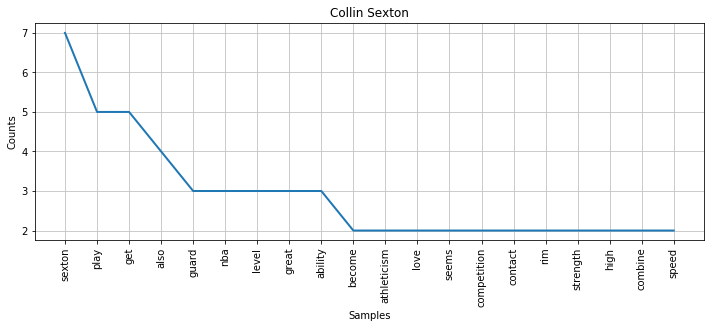

In [28]:
# Visualize frequency of most common words
plt.figure(figsize=(12,4))
fd.plot(20, title=df.loc[pid, 'Player'])

In [30]:
# Collocations
Text(words).collocations()

ValueError: too many values to unpack (expected 2)

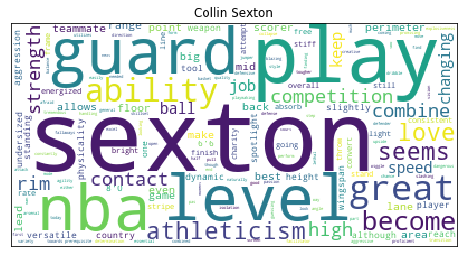

In [31]:
# Word Cloud
wc = WordCloud(background_color='white').generate(' '.join(words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title(df.loc[pid, 'Player']);

OK great, we can analyze a single report for a single player ... how can we analyze the scouting reports for multiple players? In order to do this, we need to assemble our scouting reports into a *corpus*, which is a collection of documents. In our case a "document" is a scouting report for a particular player, and the collection will cover the entire set of players.

In [32]:
# Process strength reports and assemble into corpus
reports = []
for pid in df.index:
    if type(df.at[pid, 'Strengths']) == str:
        reports.append(standardize_report(pid))
len(reports)

DeAndre Ayton 7-0 260 C Arizona Fr. 

Marvin Bagley 6-11 235 PF Duke Fr. 

Jaren Jackson Jr. 6-11 240 PF Michigan St. Fr. 

Luka Doncic 6-8 225 SG/SF Slovenia Intl. 

Michael Porter 6-10 215 SF Missouri Fr. 

Trae Young 6-2 180 PG Oklahoma Fr. 

Wendell Carter 6-10 260 PF/C Duke Fr. 

Mohamed Bamba 7-0 220 C Texas Fr. 

Mikal Bridges 6-7 210 SG/SF Villanova Jr. 

Collin Sexton 6-2 185 PG Alabama Fr. 

Kevin Knox 6-9 215 SF/PF Kentucky Fr. 

Miles Bridges 6-7 230 SF/PF Michigan St. So. 

Lonnie Walker 6-4 200 SG Miami Fr. 

Khyri Thomas 6-3 210 PG/SG Creighton Jr. 

Robert Williams 6-9 240 PF/C Texas A&M So. 

Zhaire Smith 6-5 195 SG Texas Tech Fr. 

Anfernee Simons 6-3 180 PG/SG Undecided HSSr. 

Gary Trent Jr. 6-6 215 SG Duke Fr. 

Troy Brown 6-7 215 PG/SG Oregon Fr. 

Dzanan Musa 6-9 195 SF Bosnia & Herz... Intl. 

Donte DiVincenzo 6-4 205 SG Villanova So. 

Trevon Duval 6-2 190 PG Duke Fr. 

Omari Spellman 6-9 260 PF/C Villanova Fr. 

Landry Shamet 6-4 190 PG/SG Wichita State So. 



33

In [33]:
# Define dictionary of scouting reports
D = Dictionary(reports)
print('Number of documents:', D.num_docs)
print('Number of words:', D.num_pos)

Number of documents: 33
Number of words: 5704


In [34]:
# Create corpus
corpus = [D.doc2bow(report) for report in reports]
len(corpus)

33

In [35]:
# Preview bag-of-words for specific document
pid = 1
print('Number of words in document:', len(corpus[pid]))
corpus[pid][:10]

Number of words in document: 220


[(7, 2),
 (10, 1),
 (13, 3),
 (14, 1),
 (20, 1),
 (21, 4),
 (22, 1),
 (23, 2),
 (26, 2),
 (36, 1)]

In [36]:
# Report top N words from specific document
N = 10
print('Player:', df.at[pid, 'Player'])
[(i, D.get(i), count) for i, count in sorted(corpus[pid], key=lambda t: t[1], reverse=True)[:N]]

Player: Marvin Bagley


[(62, 'great', 6),
 (104, 'rim', 5),
 (115, 'shot', 5),
 (21, 'ball', 4),
 (60, 'get', 4),
 (133, 'well', 4),
 (232, 'offensive', 4),
 (13, 'around', 3),
 (52, 'foot', 3),
 (61, 'good', 3)]

In [37]:
# Determine total word counts across the entire corpus

# Create the defaultdict: total_word_count
WC = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    WC[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
word_counts = sorted(WC.items(), key=lambda w: w[1], reverse=True) 

# Print the top 5 words across all documents alongside the count
for word_id, word_count in word_counts[:10]:
    print(D.get(word_id), word_count)

good 110
shot 92
great 72
well 72
ball 70
game 58
get 58
play 58
ability 50
guard 44


In [38]:
# Assemble all words with frequencies for Word Cloud
all_words = []
for word_id, word_count in word_counts:
    all_words.extend([D.get(word_id)] * word_count)
print(len(all_words), all_words[:5])

5704 ['good', 'good', 'good', 'good', 'good']


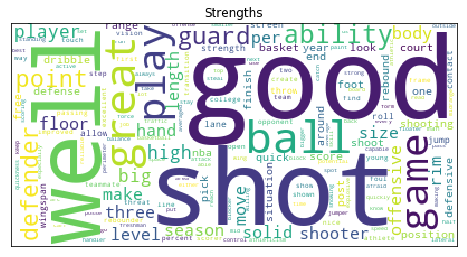

In [39]:
# Word Cloud
wc = WordCloud(background_color='white', collocations=False).generate(' '.join(all_words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('Strengths');

We have worked through some examples based on simple frequency counts of (meaningful) words. Let's extend to a more robust model, the term frequency-inverse document frequency (tf-idf) model, which captures the notion that some tokens are used more frequently in general, but may not convey much meaning about a particular document (player). Instead, we want to understand which tokens are used relatively more frequently within a document (player) than across the entire corpus.

Each word in a document is characterize by a weight that captures both the term frequency and the inverse document frequency:

$tfidf(t, d, D) = tf(t, d) * idf(t, D)$

where t is the token, d is the document, and D is the corpus. There are many forms of the *tf* and *idf* functions, but a common approach for each term is as follows:

* $tf(t, d) = f_{t,d}$, where $f_{t,d}$ is the frequency of token t in document d 

* $idf(t, D) = -log \frac{N_t}{N}$, where $N_t$ is the number of documents where token t appears and N is the total number of documents

Therefore, a high tf-idf weight means that there is high term frequency within a given document and relatively low term frequency across the corpus.

In [40]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)
print('Number of tokens:', len(tfidf.dfs))

Number of tokens: 1464


In [41]:
# Calculate the tfidf weights of specific document: tfidf_weights
pid = 1
tfidf_weights = tfidf[corpus[pid]]

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 10 weighted words for selected player
print('Player:', df.at[pid, 'Player'])
for term_id, weight in sorted_tfidf_weights[:10]:
    print(term_id, D.get(term_id), weight)

Player: Marvin Bagley
159 coast 0.15342237967427913
226 movement 0.15342237967427913
283 take 0.11632983885624512
241 pick-and-roll 0.11548780278922127
295 using 0.11548780278922127
182 elite 0.10327559672225643
136 234-pound 0.0956784782796685
138 4/5 0.0956784782796685
141 agile 0.0956784782796685
145 asset 0.0956784782796685


Now, let's calculate the tfidf weights for each player, and create a DataFrame of tfidf weights for each player.

In [42]:
# Initialize empty DataFrame
wdf = pd.DataFrame(index=range(len(tfidf.dfs)))

In [43]:
# Loop through documents in corpus
i = 0
for pid in df.index:
    if type(df.at[pid, 'Strengths']) == str:
        wdf[df.at[pid, 'Player']] = pd.Series(dict(tfidf[corpus[i]]))
        i += 1
wdf.fillna(0, inplace=True)

In [44]:
# Preview results
wdf.head(10)

,DeAndre Ayton,Marvin Bagley,Jaren Jackson Jr.,Luka Doncic,Michael Porter,Trae Young,Wendell Carter,Mohamed Bamba,Mikal Bridges,Collin Sexton,Kevin Knox,Miles Bridges,Lonnie Walker,Khyri Thomas,Robert Williams,Zhaire Smith,Anfernee Simons,Gary Trent Jr.,Troy Brown,Dzanan Musa,Donte DiVincenzo,Trevon Duval,Omari Spellman,Landry Shamet,Grayson Allen,Brandon McCoy,Elie Okobo,Tony Carr,Sviatoslav Mykhailiuk,Hamidou Diallo,Malik Newman,Goga Bitadze,Rawle Alkins
0,0.102127,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.065730,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.087356,0.000000,0.000000,0.0000,0.087346,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.056223,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.043495,0.000000,0.000000,0.0000,0.000000,0.000000,0.046271,0.0,0.036753,0.029160,0.000000,0.000000,0.0,0.039549,0.000000,0.000000,0.083982,0.000000,0.000000,0.000000,0.000000,0.0,0.042201,0.063962,0.000000,0.168335,0.000000,0.000000,0.000000,0.000000,0.060375,0.000000,0.000000
3,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.008685,0.013048,0.024554,0.0291,0.034738,0.017274,0.009240,0.0,0.007339,0.017469,0.000000,0.023814,0.0,0.000000,0.009552,0.019439,0.005590,0.010186,0.008998,0.009689,0.016239,0.0,0.008427,0.025545,0.008527,0.000000,0.039395,0.000000,0.008974,0.017196,0.012056,0.018477,0.007977
8,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.043495,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.029160,0.047938,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.051012,0.000000,0.048522,0.000000,0.0,0.000000,0.000000,0.000000,0.056112,0.039457,0.027896,0.000000,0.043057,0.000000,0.092528,0.000000


Now that we have report-based features for each player's strengths, let's perform clustering in order to determine whether there are similar groups of players.

In [52]:
# Define and fit KMeans cluster object
k = 5
cluster = KMeans(n_clusters=k)
cluster.fit(wdf.T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [53]:
# Determine cluster sizes
cid = cluster.predict(wdf.T)
pd.Series(cid).value_counts().sort_index()

0     6
1     5
2    14
3     4
4     4
dtype: int64

In [54]:
# Merge cluster membership with player data frame
pd.merge(df, pd.DataFrame(cid, index=wdf.columns, columns=['Cluster']), left_on='Player', right_index=True).drop(labels=['url','Strengths','Weaknesses'], axis=1).sort_values(by='Cluster')

,#,Team,Player,H,W,P,School,C,Cluster
18,19,Atlanta,Anfernee Simons,6-3,180,PG/SG,Undecided,HSSr.,0
46,47,LA Lakers,Malik Newman,6-3,190,SG,Kansas,So.,0
3,4,Atlanta,Luka Doncic,6-8,225,SG/SF,Slovenia,Intl.,0
14,15,Washington,Khyri Thomas,6-3,210,PG/SG,Creighton,Jr.,0
8,9,New York,Mikal Bridges,6-7,210,SG/SF,Villanova,Jr.,0
7,8,Cleveland,Mohamed Bamba,7-0,220,C,Texas,Fr.,0
29,30,Atlanta,Brandon McCoy,7-0,255,C,UNLV,Fr.,1
0,1,Phoenix,DeAndre Ayton,7-0,260,C,Arizona,Fr.,1
2,3,Dallas,Jaren Jackson Jr.,6-11,240,PF,Michigan St.,Fr.,1
6,7,Sacramento,Wendell Carter,6-10,260,PF/C,Duke,Fr.,1


In [48]:
# Assemble cluster centers into dataframe
ccdf = pd.DataFrame(cluster.cluster_centers_)
ccdf.columns = [D.get(i) for i in ccdf.columns]
ccdf.head()

,1%,2%,5,60,7'5,82,9'3,ability,accurate,afraid,agility,alters,another,around,athlete,attention,attracts,avoid,awareness,away,...,alkins',almost,among,arizona,assume,boy,carve,category,contain,continue,enticing,filled,future,improving,loose,maintaining,out-compete,roster,showcase,up-tempo
0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.010387,0.000000e+00,1.011047e-02,0.015265,0.000000e+00,-8.673617e-19,0.025017,9.064955e-03,8.673617e-19,0.000000e+00,0.000000,9.558756e-03,0.012962,...,1.299822e-02,1.299822e-02,1.299822e-02,2.599644e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02
1,0.000000,-8.673617e-19,0.000000,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,0.017009,-4.336809e-19,3.307422e-02,0.000000,-4.336809e-19,0.000000e+00,0.009282,1.997236e-02,8.673617e-19,-4.336809e-19,0.013235,-1.734723e-18,0.000000,...,-4.336809e-19,-4.336809e-19,-4.336809e-19,-8.673617e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19
2,0.020425,3.494043e-02,0.051620,2.547567e-02,2.547567e-02,2.547567e-02,2.547567e-02,0.015443,2.547567e-02,1.992126e-02,0.015375,2.547567e-02,4.677563e-02,0.028371,2.233021e-02,4.215443e-02,2.547567e-02,0.020425,5.156651e-02,0.047107,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.009390,8.031908e-03,0.028926,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,0.007208,-4.336809e-19,-1.734723e-18,0.000000,-4.336809e-19,0.000000e+00,0.017384,-1.734723e-18,8.673617e-19,-4.336809e-19,0.000000,-1.734723e-18,0.000000,...,-4.336809e-19,-4.336809e-19,-4.336809e-19,-8.673617e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19
4,0.000000,0.000000e+00,0.030699,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.014262,0.000000e+00,1.141130e-02,0.010308,0.000000e+00,0.000000e+00,0.004336,1.568885e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.014373,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [55]:
# Report top N words for each cluster
N = 10
for i in ccdf.index:
    print('Cluster', i, '\n')
    sorted_weights = ccdf.loc[i].sort_values(ascending=False)
    print(sorted_weights.head(N), '\n')

Cluster 0 

young       0.059814
alkins      0.051993
knack       0.048231
teammate    0.045936
able        0.044351
allows      0.042667
guard       0.042577
look        0.042229
pass        0.041412
rebound     0.040779
Name: 0, dtype: float64 

Cluster 1 

n'           0.058067
opponent     0.055076
roll         0.052761
situation    0.049927
result       0.045577
used         0.043858
steal        0.043480
drive        0.042902
improved     0.041740
every        0.041541
Name: 1, dtype: float64 

Cluster 2 

nike        0.118506
eybl        0.118506
reliable    0.083315
ground      0.068825
within      0.066938
shoot       0.066186
man         0.064726
run         0.060486
reach       0.059546
stroke      0.056942
Name: 2, dtype: float64 

Cluster 3 

3              0.080314
armour         0.070271
association    0.070271
able           0.050594
college        0.049525
bamba          0.049471
per            0.047310
100            0.046847
nbpa           0.046847
outside        0.0

## Discussion: Potential Improvements

Given our natural language processing and analysis, what potential improvements could we make to our approach?

## Next Time: Optimization